# PCA->k-means Image Classifier: Step 4

In [1]:
#%load_ext autotime
#%load_ext autoreload
#%autoreload 2

import joblib

from cls import *

from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, SpectralClustering, OPTICS
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.cm as cm

Welcome to eht-imaging! v 1.2.4 



## Load features

In [2]:
Y = joblib.load('Y.joblib')

## Find Optimal Number of Clusters Using Average Silhouette Score

In [ ]:
#The following code is from https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html
#The number of clusters with the maximum average silhouette score is the optimal number of clusters

range_n_clusters = [9,29,33,41,42,43]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(Y) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(Y)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(Y, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(Y, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(
        Y[:, 0], Y[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )

plt.show()

## Apply Clustering

In [ ]:
'''
minpts = 4                                         #https://medium.com/@tarammullin/dbscan-parameter-estimation-ff8330e3a3bd
                                                   #This is used for estimating epsilon in DBSCAN clustering
from sklearn.neighbors import NearestNeighbors     #the article also has information about choosing minpts

neighbors = NearestNeighbors(n_neighbors= minpts)  #minpts might also be used for OPTICS(?)
neighbors_fit = neighbors.fit(Y)
distances, indices = neighbors_fit.kneighbors(Y)
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)
'''

In [3]:
#K    = 32
#kmap = KMeans(n_clusters=K).fit_predict(Y)
#above is the old Kmeans code


print('Note: For the clustering comparisons between two algorithms in the next notebook,')
print('      you should ensure that the two algorithms that you wish to compare have the')
print('      same number of clusters. As DBSCAN and OPTICS do not take a number of clusters')
print('      in as a parameter, you should enter appropriate matching numbers of clusters')
print('      for the other algorithms that do, should you wish to compare them effectively.')
print()
print('Abbreviations:')
print('"k" for K-means')
print('"a" for Agglomerative')
print('"d" for DBSCAN')
print('"s" for Spectral')
print('"o" for OPTICS')


#==============================================================================
#=========================BEGINNING OF ALGORITHMS==============================
#==============================================================================


#Kmeans++ clustering (centroid-based)
def K(X):
    nclus = int(input('Enter a presumed number of clusters for the data set (integers only) (k): '))
    km = KMeans(n_clusters=nclus, init='k-means++', n_init=10, max_iter=10000,
                tol=1e-4, random_state=0)
    a = km.fit_predict(X)
    return a


#Agglomerative clustering (hierarchical)
def A(X):
    nclus = int(input('Enter a presumed number of clusters for the data set (integers only) (a): '))
    ac = AgglomerativeClustering(n_clusters=nclus, affinity='euclidean',
                                 linkage='complete')
    return ac.fit_predict(X)


#DBSCAN clustering (density-based)
def D(X):
    minpts = int(input('Enter the minimum closest neighbors to be considered a core point (integers only) (d): '))
    ep = float(input('Enter "epsilon", the distance within which two points will be considered neighboring points (floats okay) (o): '))
    db = DBSCAN(eps=ep, min_samples=minpts, metric='euclidean')
    return db.fit_predict(X)


#Spectral clustering
def S(X):
    nclus = int(input('Enter a presumed number of clusters for the data set (integers only) (s): '))
    sc = SpectralClustering(n_clusters = nclus, eigen_tol = 1e-3)
    return sc.fit_predict(X)  #Try later feeding in fewer images, different eigensolvers


#OPTICS clustering
def O(X):
    minmem = float(input('Enter the minimum closest neighbors to be considered a core point (integer or fraction of total points) (o): '))
    ep = float(input('Enter "epsilon_max", the maximum radius between neighboring points (infinite by default) (floats okay) (o): '))
    if minmem > 1:
        minmem = int(minmem)
    op = OPTICS(min_samples = minmem, max_eps = ep)
    return op.fit_predict(X)


#==============================================================================
#=============================END OF ALGORITHMS================================
#==============================================================================


print()
print('Which algorithms would you like to use? (enter the appropriate abbreviations shown above')
algo = input('and separate multiple algorithms with spaces): ')
print()
kmap_k = np.zeros(4045, int) - 1  #the images labelled with index -1 are outliers/null
kmap_a = np.zeros(4045, int) - 1  #since 0 is used to index the first cluster
kmap_d = np.zeros(4045, int) - 1
kmap_s = np.zeros(4045, int) - 1
kmap_o = np.zeros(4045, int) - 1
for i in algo:
    if i == 'k':
        kmap_k = K(Y)
    if i == 'a':
        kmap_a = A(Y)
    if i == 'd':
        kmap_d = D(Y)
        maximum = 0
        for i in kmap_d:
            if i > maximum:
                maximum = i
        print('DBSCAN with the given parameters resulted in',maximum + 1,'clusters')
    if i == 's':
        kmap_s = S(Y)
    if i == 'o':
        kmap_o = O(Y)
        maximum = 0
        for i in kmap_o:
            if i > maximum:
                maximum = i
        print('OPTICS with the given parameters resulted in',maximum + 1,'clusters')
        
kmap = np.vstack((kmap_k, kmap_a, kmap_d, kmap_s, kmap_o))
print(kmap)

Note: For the clustering comparisons between two algorithms in the next notebook,
      you should ensure that the two algorithms that you wish to compare have the
      same number of clusters. As DBSCAN and OPTICS do not take a number of clusters
      in as a parameter, you should enter appropriate matching numbers of clusters
      for the other algorithms that do, should you wish to compare them effectively.

Abbreviations:
"k" for K-means
"a" for Agglomerative
"d" for DBSCAN
"s" for Spectral
"o" for OPTICS

Which algorithms would you like to use? (enter the appropriate abbreviations shown above
and separate multiple algorithms with spaces): ok

Enter the minimum closest neighbors to be considered a core point (integer or fraction of total points) (o): 15
Enter "epsilon_max", the maximum radius between neighboring points (infinite by default) (floats okay) (o): 9999999999999999
OPTICS with the given parameters resulted in 29 clusters
Enter a presumed number of clusters for the dat

### Save Clustering

In [4]:
joblib.dump(kmap, 'kmap.joblib')

['kmap.joblib']

## Visualize

In [6]:
tsne_results = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300).fit_transform(Y)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 4045 samples in 0.018s...
[t-SNE] Computed neighbors for 4045 samples in 0.871s...
[t-SNE] Computed conditional probabilities for sample 1000 / 4045
[t-SNE] Computed conditional probabilities for sample 2000 / 4045
[t-SNE] Computed conditional probabilities for sample 3000 / 4045
[t-SNE] Computed conditional probabilities for sample 4000 / 4045
[t-SNE] Computed conditional probabilities for sample 4045 / 4045
[t-SNE] Mean sigma: 1.276142
[t-SNE] KL divergence after 250 iterations with early exaggeration: 61.991547
[t-SNE] KL divergence after 300 iterations: 1.229817


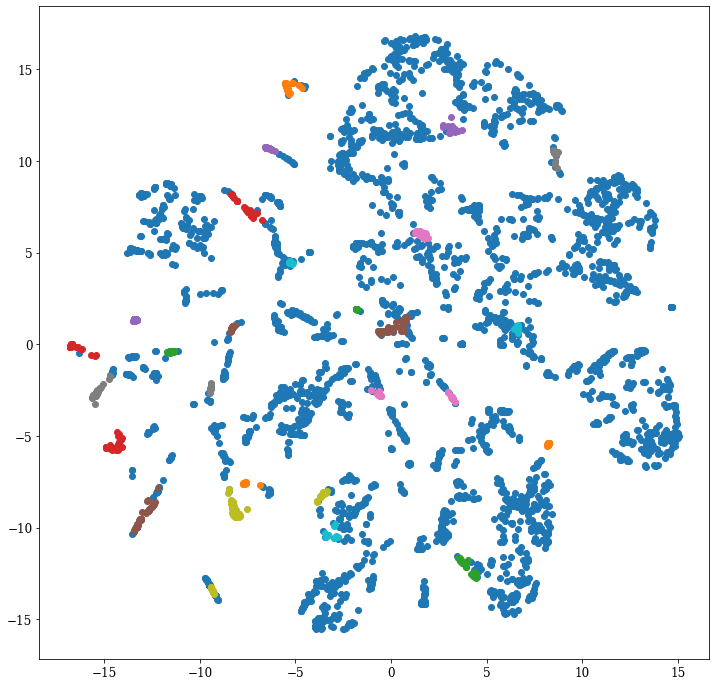

In [8]:
#Reminder: k is 0, a is 1, d is 2, s is 3, o is 4

alg = 4

kc   = dict(zip(*np.unique(kmap, return_counts=True)))
keys = list({k: v for k, v in sorted(kc.items(), key=lambda v: v[1], reverse=True)}.keys())

plt.rcParams["figure.figsize"] = (12,12)
for k in keys:
    plt.scatter([tsne_results[w,0] for w in np.where(kmap[alg] == k)[0]],[tsne_results[w,1] for w in np.where(kmap[alg] == k)[0]])